### 任务流程

1. 获得共同项目数据集(所有用户的，且独立到程序外的)（可选方案之一）
1. 先取得初始数据

3. 获得随机用户和随机评分项目
4. 修改目标项目评分
6. 计算平均评分
5. 获得共同项目数据集  (只获得目标用户相关即可)
7. 计算pearson系数   （只计算目标用户相关即可）
8. 找出近邻（需要一个最低相关度，或者一个topK）
9. 产生预测
12. 恢复数据
10. 重复3~8步，并记录数据值
11. 对照原始数据，计算评分

`存在问题：若随机获得的两用户相似度很低，又该如何`

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./movie_lens/ratings.csv')
data = data.drop('timestamp',axis=1)
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null int64
movieId    100836 non-null int64
rating     100836 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


#### 计算用户的平均评分

In [4]:
def average(data):
    rate_average = round( data.groupby(['userId'])['rating'].sum() / data.groupby(['userId'])['rating'].count() , 4)
    return rate_average

In [119]:
rate_average = average()
rate_average.head()

userId
1    4.3664
2    3.9483
3    2.4359
4    3.5556
5    3.6364
Name: rating, dtype: float64

#### 计算并获得共同评分项目数据集
``` userId_1 userId_2 movieIds
```

`抽出所有的共同评分的数据信息`

In [128]:
def common_file(data,common_name):
    f = open(common_name, 'w', encoding='utf8')
    f.write('userId_1,userId_2,movieIds\n')
    id_list = []
    for j in data['userId']:     #这里的迭代体 5 是用户数，假定用户1为比较用户，用户2为被比较用户，此处显然为用户1的个数
        if j ==0 :continue
        for i in data['userId']:    #这里的迭代体 11 是用户2的个数
            if i == 0 : continue
            if j == i : continue
                #获得电影编号
            if [j,i] in id_list or [i,j] in id_list:
                continue
            else:
                id_list.append([i,j])
            movie_1 = data[data['userId']==j]
            movie_2 = data[data['userId']==i]
            f.write( str(j) +','+str(i)+',')
            for m_id in movie_1['movieId']:                   #遍历用户1的项目，每个都拿去在用户2的项目里检索
                judge = movie_2[movie_2['movieId'] == m_id]    #为获得共有电影编号参数 number 做准备
                number = judge['movieId']
                if judge.empty: 
                    pass                          #检查是否有共同项目，无则pass，有则写入文件
                else:  
                    f.write(str(int(number)) + ' ')
            f.write('\n')
    f.close()

In [ ]:
common_file(101)

#### 获得与目标用户有关的共同项目集

In [6]:
#制作公共影片文件  common.txt
def common_file(common_name,user_1,user_number):
    #获得公共影片信息
    #movie_1就是用户j评过分的电影,同理movie_2就是用户i评过分的电影
    f = open( common_name, 'w', encoding='utf8')
    f.write('userId_1,userId_2,movieIds\n')
    movie_1 = data[data['userId']==user_1]
    for user_2 in range(user_number):     #这里的迭代体 5 是用户数，假定用户1为比较用户，用户2为被比较用户，此处显然为用户1的个数
        if user_2 ==0 :continue
        if user_2 == user_1 : continue
                #获得电影编号
        movie_2 = data[data['userId']==user_2]
        f.write( str(user_1) +','+str(user_2)+',')
        for m_id in movie_1['movieId']:                   #遍历用户1的项目，每个都拿去在用户2的项目里检索
            judge = movie_2[movie_2['movieId'] == m_id]    #为获得共有电影编号参数 number 做准备
            Id = judge['movieId']
            if judge.empty: pass                          #检查是否有共同项目，无则pass，有则写入文件
            else:  
                f.write(str(int(Id)) + ' ')
        f.write('\n')
    f.close()

In [116]:
common_name = 'test2.txt'
common_file(common_name,5)

#### 取出共同评分项目数据集

In [7]:
def load_common(common_name): 
    common = pd.read_table(common_name,sep=',')
    common = common.fillna(0)
    return common

#### 获得共同项目中对应用户的评分

In [8]:
#生成pearson数值
#此函数无输出，但会生成文件:person.txt
def pearson_file(common,rate_average):
    
    '''
        common:共同评分项目的数据
        rate_average:各个用户的平均评分，索引为userId
        data:原始数据，用于获取评分值
    '''
        
    user = []
    length = len(common)   #存下总数据数
    person = []            #用来存储查看数据  [user1,user2,person]
    f = open( 'pearson.txt', 'w', encoding='utf8')
    f.write('user1,user2,pearson\n')
    for num in range(length):
        user1 = int(common.loc[num][0])          #拿到用户一的  id
        user2 = int(common.loc[num][1])
        if common.loc[num][2] == 0: continue     #当两用户无共同项目时，跳过
        user.append([user1,user2])               #记录当前计算用户id
        movie_common = common.loc[num][2].split()   #存储共同项目
        rating1 = 0
        rating2 = 0
        rating3 = 0
        for movie_id in movie_common:                 #对每个共同项目进行计算
            movie = data[data['movieId'] == int(movie_id)]
                                                         #拿到对应的个人评分
            rating_user1 = float( movie[movie['userId'] == user1]['rating'] ) 
            rating_user2 = float( movie[movie['userId'] == user2]['rating'] ) 
                                                         #开始进行累加的每一步
            rating1 += (rating_user1 - rate_average[user1])*(rating_user2 - rate_average[user2])
            rating2 += math.pow(rating_user1 - rate_average[user1],2)
            rating3 += math.pow(rating_user2 - rate_average[user2],2)
                                                        #计算最后的person得分
        rating = round( rating1/ ( math.sqrt(rating2) * math.sqrt(rating3) ) ,4)
        person.append([user1,user2,rating])
        f.write(str(user1)+','+str(user2)+','+str(rating)+'\n')
    f.close()

# pearson(common,rate_average,data)

In [66]:
#生成pearson数值
#此函数无输出，但会生成文件:person.txt
def get_pearson(pearson_name,user_1,train_data,rate_average):
    user = []
    f = open( pearson_name, 'w', encoding='utf8')
    f.write('user1,user2,pearson\n')
#     num = 0
    user1_data = train_data[train_data['userId'] == user_1]
    for user_2 in train_data['userId']:
        if user_1 == user_2:
            continue
        if [user_1,user_2] in user or [user_2,user_1] in user:
            continue
        else:
            user.append([user_1,user_2])
        user2_data = train_data[train_data['userId'] == user_2]
        movies = [x1  for x1 in user1_data['movieId'] for x2 in user2_data['movieId'] if x1==x2]
        rating1 = sum( [( float( user1_data[user1_data['movieId'] == movie_id]['rating'] - rate_average[user_1] ) ) *
                         ( float( user2_data[user2_data['movieId'] == movie_id]['rating'] - rate_average[user_2]) )
                         for movie_id in movies] )
        rating2 =  sum(  [ ( float( user1_data[user1_data['movieId'] == movie_id]['rating'] - rate_average[user_1]) ) **2 
                              for movie_id in movies] )  
        rating3 =  sum(  [ ( float( user2_data[user2_data['movieId'] == movie_id]['rating'] - rate_average[user_2]) ) **2 
                              for movie_id in movies] )  
        if rating2 == 0 or rating3 == 0:
            rating = 0
        else:
            rating = round( rating1/ ( math.sqrt(rating2) * math.sqrt(rating3) ) ,4)
        f.write(str(user_1)+','+str(user_2)+','+str(rating)+'\n')
#         num += 1
#         print('\r'+'▇'*(num//31)+str(round(num/6.1,2))+'%', end='')
    f.close()

# pearson(common,rate_average,data)

In [150]:
ll = [1,2,3]
sum(ll)

6

In [171]:
user1 = x_train[x_train['userId'] == 483]
user2 = x_train[x_train['userId'] == 599]
user1_data = train[train['userId'] == 483]
user2_data = train[train['userId'] == 599]
movies = [x1  for x1 in user1['movieId'] for x2 in user2['movieId'] if x1==x2]
rating1 = [ ( float(user1_data[user1_data['movieId'] == movie_id]['rating']) - rate_average[483]) *
                         ( float( user2_data[user2_data['movieId'] == movie_id]['rating'] ) - rate_average[599]) 
                         for movie_id in movies] 
rating1 = sum(rating)
rating1
# rating = [ float( user1_data[user1_data['movieId'] == movie_id]['rating']) - rate_average[483]  for movie_id in movies]
# rating

-15.78309999999985

In [149]:
train.head()

,userId,movieId,rating
77701,483,8529,4.0
94477,599,33437,2.5
36246,247,5349,2.0
17483,111,7361,3.5
100300,610,57504,4.5


In [6]:
def load_pearson(pearson_name):
    pearson = pd.read_table(pearson_name,sep=',')
    return pearson

#### 计算并返回最近邻

In [69]:
def neighbour(pearson,user,movie,pearson_rate,pearson_number):
    pearson = pearson[pearson['user1'] == user]
    pearson = pearson[pearson['pearson'] > pearson_rate]
    neighbours = []
    for one in pearson['user2']:
        if verify(one,movie):
            neighbours.append(int(one))
        else:
            continue
    neighbours.sort(reverse = True)
#     if pearson_number > 0:
#         neighbours = neighbours[0:pearson_number]
#     print("neighbour work well")
    return neighbours

In [15]:
def neighbour(pearson_data,user,pearson_rate,pearson_number):
    pearson = pearson_data[pearson_data['user1'] == user]
    pearson = pearson[pearson['pearson'] > pearson_rate]
    neighbours = []
    for one in pearson['user2']:
        neighbours.append(int(one))
    neighbours.sort(reverse = True)
    if pearson_number > 0:
        neighbours = neighbours[0:pearson_number]
    return neighbours

#### 验证该用户是否有目标项目的评分

In [37]:
def verify(user2,movie):
    user2_data = data[data['userId']==user2]
    if user2_data[user2_data['movieId']==movie]['rating'].empty:
        return False
    else:
        return True

In [36]:
user2_data = data[data['userId']==10]
if user2_data[user2_data['movieId']==88]['rating'].empty:
    print("ok")

ok


In [30]:
movie

88

#### 计算随机的movieId

In [13]:
def random_movie(user_random):
    res = data[data['userId']==user_random]
    res.reset_index(drop=True, inplace=True)
    movies = []
    for one in res['movieId']:
        movies.append(int(one))
    random.shuffle(movies)
    if movies[0] == 0: random_movie(user_random)
    else:
        return movies[0]

#### 取得制造的随机数

In [68]:
def get_random(user_number):
#     start = random.randint()
    user_random = random.randint(1,user_number)
    movie_id = random_movie(user_random)
#     print("get_random work well")
    return [user_random,movie_id]

#### 修改获得的随机用户的项目项目

In [67]:
def edit_rating(the_random,rating=0):
    user = the_random[0]
    movie_id = the_random[1]
    fake = data[data['userId']==user]
    y_rating = fake.loc[ fake[fake['movieId'] == movie_id].index ]['rating']
    fake.loc[ fake[fake['movieId'] == movie_id].index , 'rating']= rating
    data[data['userId']==user] = fake
#     print("edit_rating work well")
    return y_rating

#### 恢复被修改的评分数值

In [66]:
def recovery(user,movie,y_rating):
    fake = data[data['userId']==user]
    fake.loc[ fake[fake['movieId'] == movie].index , 'rating']= y_rating
    data[data['userId']==user] = fake
#     print("recovery work well")

In [128]:
the_random = get_random(user_number)
y_rating = float(edit_rating(the_random))
print(the_random)
print(y_rating)

[13, 597]
3.0


D:\anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### 预测函数

In [105]:
def pridect(pearson_data,user,movie,rate_average,neighbours):
    user_1 = user
    rating_1 = 0
    rating_2 = 0
    y_pridect = 0
    user_2_rating = 0
    for user_2 in neighbours:
        if pearson_data[pearson_data['user2']==user_2]['pearson'].empty:
            continue
        else:
            pearson_rating = float(pearson_data[pearson_data['user2']==user_2]['pearson'])
        if pearson_rating == 0:
            continue
        user_2_rating = data[data['userId'] == user_2]
        if user_2_rating[user_2_rating['movieId'] == movie]['rating'].empty:
            continue
        else:
            user_2_rating = float(user_2_rating[user_2_rating['movieId'] == movie]['rating'])
        rating_1 +=  pearson_rating * ( user_2_rating - rate_average[user_2])
        rating_2 +=  abs(pearson_rating)
    if rating_2 == 0:
        y_pridect = 'error'
    else:
        y_pridect = round( rate_average[user_1] + rating_1 / rating_2 ,1)
    return y_pridect

In [181]:
float(pearson[pearson['user2']==49]['pearson'])

1.0

In [58]:
user2 = data[data['userId'] == 12]
user2 = user2[user2['movieId']==543]
user2

,userId,movieId,rating
1330,12,543,3.5


In [27]:
#测试获得平均评分函数
rate_average = average(data)
rate_average.head()

userId
1    4.3664
2    3.9483
3    2.4359
4    3.5556
5    3.6364
Name: rating, dtype: float64

In [22]:
#测试获得随机用户和评分项目函数
the_random = get_random_movie(common,user_number)
the_random

[6, 3, 31]

In [20]:
#测试获得共同项目数据集文件函数
common_name = 'common.txt'
user_number = 10
common_file(data,common_name,user_number)
common = load_common()

In [ ]:
#测试pearson数据集文件获取函数
pearson(data,common,rate_average,data)

### test1 :每次选取一个项目清空，计算MAE值做评价标准
* 用户数定100，即user_number=100

In [80]:
user_number = 100 #设置最大用户数
user_number += 1
common_name = 'test1.txt'
pearson_rate = 0.1
pearson_number = 5  #最大近邻数，还未写

mae = 0
num = 0
for time in range(100):
    
    the_random = get_random(user_number)      #拿到随机数据，形式为 [user_random,movie_random]
    user = the_random[0]
    movie = the_random[1]
    
    y_rating = float(edit_rating(the_random))    #修改并拿到随机项目的原始评分
    
    rate_average = average()                  #拿到平均评分

    common_file(common_name,user,user_number)      #写共同项目文件
    
    common = load_common(common_name)         #拿到共同项目数据
    
    pearson_file(common,rate_average)         #计算pearson系数，生成文件
    
    pearson = load_pearson()          #拿到pearson数值
    
    neighbours = neighbour(pearson,user,movie,pearson_rate,pearson_number)
    #获得近邻列表,有两个可选参数，一个pearson_rate，一个pearson_number
    if len(neighbours)<=2:
#         print("neighbours is too little!")
        continue
    
    y_predict = pridect(pearson,user,movie,rate_average,neighbours)              #预测评分
    
    mae += (y_rating - y_predict)*(y_rating - y_predict)
    num += 1
    
    recovery(user,movie,y_rating)         #还原数据集，准备进行下一次循环
    
    
    
#     print('predict rating is %s'%y_predict)
#     print(the_random)
#     print('true rating is %s'%y_rating)
#     print(neighbours)
#     print('*'*50)
mae = mae/num
print("mae is %s"%mae)

D:\anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


mae is 1.278235294117648


In [ ]:
# mae is 0.9009090909090911   user_number = 80   loop = 20  pearson_rate = 0.1
# mae is 0.44    user_number = 100   loop = 10  pearson_rate = 0.1
# mae is 1.278235294117648  user_number = 100   loop = 100  pearson_rate = 0.1

### test2:使用sklearn划分数据集，使用8:2来划分，对测试集进行预测

3.28%

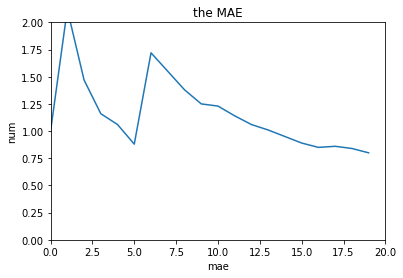

In [106]:
pearson_name = 'pearson.txt'
test_size = 0.2
pearson_rate = 0.5
pearson_number = 10
the_break = 20

x,y = data.ix[:,:2],data.ix[:,2]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=0)
train = x_train.copy(deep=True)
train['rating'] = y_train
rate_average = average(train) 

mae = []
number = 0
deta = 0

for user_data in x_test.itertuples(index=True):
    id_index = user_data[0]
    user_id = user_data[1]
    movie = user_data[2]
    get_pearson(pearson_name,user_id,train,rate_average)
    pearson_data = load_pearson(pearson_name)
    neighbours = neighbour(pearson_data,user_id,pearson_rate,pearson_number)
    y_predict = pridect(pearson_data,user_id,movie,rate_average,neighbours)
    if y_predict == 'error':
        continue
    y_rating = y_test[id_index]
    number += 1
    deta += (y_rating - y_predict)*(y_rating - y_predict)
    mae.append( round(deta/number,2) )
    print('\r'+'▇'*(number//31)+str(round(number/6.1,2))+'%', end='')
    if number==the_break:
        break
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(xlim=[0, number], ylim=[0,2], title='the MAE',
       ylabel='mae', xlabel='num')
x = [one for one in range(number)]
mae_data = pd.DataFrame(mae)
mae_data.rename(columns={0:'mae'},inplace=True)
mae_data.to_csv('mae.csv', sep=' ', header=True, index=True)
ax.plot(x, mae)
plt.savefig('mae1.png', format='png')
plt.show()

In [103]:
mae = [1,2,3,4,5,6]
mae_data = pd.DataFrame(mae)
mae_data.rename(columns={0:'mae'},inplace=True)
# mae_data
mae_data.to_csv('mae.csv', sep=' ', header=True, index=True)

In [118]:
x,y = data.ix[:,:2],data.ix[:,2]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
x_train.head()

,userId,movieId
77701,483,8529
94477,599,33437
36246,247,5349
17483,111,7361
100300,610,57504


In [119]:
y_train.head()

77701     4.0
94477     2.5
36246     2.0
17483     3.5
100300    4.5
Name: rating, dtype: float64

In [120]:
train = x_train.copy(deep=True)
train['rating'] = y_train
train.head()

,userId,movieId,rating
77701,483,8529,4.0
94477,599,33437,2.5
36246,247,5349,2.0
17483,111,7361,3.5
100300,610,57504,4.5


In [12]:
x_test.head()

,userId,movieId
41008,276,780
94274,599,7624
77380,483,1320
29744,202,3448
40462,274,60291


In [10]:
y_test.head()

41008    5.0
94274    2.5
77380    2.5
29744    3.0
40462    4.0
Name: rating, dtype: float64

In [53]:
for user in x_test.itertuples(index=True):
    print(user[0:3])
    break

(41008, 276, 780)


In [58]:
y_test[41008]

5.0